In [1]:
import requests
from iexfinance import get_available_symbols
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

## Sampling Data Stream

#### Step 1 : Get Sample Space (Previous Month Stock per Day, per Minute)

In [109]:
today = date.today()
d = today - relativedelta(months=1)
start_date = date(d.year, d.month, 1)
end_date = date(today.year, today.month, 1) - relativedelta(days=1)
today = date.today()
datelist = pd.bdate_range(start_date,today).tolist()
dateRange = []
for curr in datelist :
    dateRange.append(curr.strftime('date/%Y%m%d'))
dateRange.pop()
dateRange.append('1d')

In [110]:
json_dat= get_available_symbols()
sym = ""
symbols = []
for x in json_dat :
    symbols.append(str(x['symbol']))
    sym += "," + str(x['symbol'])

#### Step 2 : Randomize Date and Company (Random Sampling)

In [111]:
num_sample = (len(symbols) * len(dateRange))//1000
num_sample

297

In [ ]:
json_result = []
samples = []
for i in range(0,num_sample):
    comp_name = random.choice(symbols)
    x_date = random.choice(dateRange)
    while (comp_name,x_date) in samples :
        comp_name = random.choice(symbols)
        x_date = random.choice(dateRange)
    
    contents = []
    while contents == []:
        comp_name = random.choice(symbols)
        x_date = random.choice(dateRange)
        queryStr = "https://api.iextrading.com/1.0/stock/"+ comp_name +"/chart/" + x_date
        contents = requests.get(queryStr).json()
    samples.append((comp_name,x_date))
    for x in contents :
        x['company'] = comp_name
    json_result += contents

In [ ]:
random.shuffle(json_result)

In [13]:
pd.DataFrame(json_result).head()

,average,changeOverTime,close,company,date,high,label,low,marketAverage,marketChangeOverTime,...,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,minute,notional,numberOfTrades,open,volume
0,-1.000,NaN,NaN,ABR-C,20181128,-1.000,11:04 AM,-1.000,-1.000,-1.039216,...,-1.000,0.0000,0.0,NaN,0.0,11:04,0.0,0,NaN,0
1,-1.000,NaN,NaN,NTC,20181105,-1.000,09:37 AM,-1.000,11.067,0.001538,...,11.067,9053.0900,3.0,11.070,818.0,09:37,0.0,0,NaN,0
2,-1.000,NaN,NaN,HLF,20181113,-1.000,09:59 AM,-1.000,54.690,0.001630,...,54.630,80941.0100,16.0,54.700,1480.0,09:59,0.0,0,NaN,0
3,3.715,-4.715,3.715,ZNGA,20181217,3.715,2:18 PM,3.715,3.714,0.003784,...,3.710,21889.4597,41.0,3.715,5894.0,14:18,371.5,1,3.715,100
4,-1.000,NaN,NaN,IYM,20181207,-1.000,3:27 PM,-1.000,85.568,-0.028652,...,85.568,27296.1920,2.0,85.568,319.0,15:27,0.0,0,NaN,0


## Filtering Data Stream

#### Step 1 : Set Company With Most Activity

In [2]:
symbols = ['GOOGL','TSLA','AAPL','DIS','FB','A','IBM','LMT','KRX','AMZN','NFLX']

#### Step 2 : Set Sample Date Range

In [3]:
today = date.today()
d = today - relativedelta(months=1)
start_date = date(d.year, d.month, 1)
end_date = date(today.year, today.month, 1) - relativedelta(days=1)
today = date.today()
datelist = pd.bdate_range(start_date,today).tolist()
dateRange = []
for curr in datelist :
    dateRange.append(curr.strftime('date/%Y%m%d'))
dateRange.pop()
dateRange.append('1d')

#### Step 3 : Define Hash Function

In [4]:
basket_keys = ['p_very_low', 'p_low','p_avg_low', 'p_avg_high', 'p_high', 'p_very_high',
                'n_very_low', 'n_low', 'n_avg_low', 'n_avg_high', 'n_high', 'n_very_high']
baskets = {key: [] for key in basket_keys}

In [5]:
def h_func(item):
    if item['changeOverTime'] == None :
        return None
    reactive_change = int(item['changeOverTime'] // 0.0001)
    if item['changeOverTime'] > 0 :
        if reactive_change > 100000 :
            return 'p_very_high'
        elif reactive_change > 10000 :
            return 'p_high'
        elif reactive_change > 1000 :
            return 'p_avg_high'
        elif reactive_change > 100 :
            return 'p_avg_low'
        elif reactive_change > 10 :
            return 'p_low'
        else :
            return 'p_very_low'
    elif item['changeOverTime'] < 0 :
        if reactive_change < -100000 :
            return 'n_very_high'
        elif reactive_change < -10000 :
            return 'n_high'
        elif reactive_change < -1000 :
            return 'n_avg_high'
        elif reactive_change < -100 :
            return 'n_avg_low'
        elif reactive_change < -10 :
            return 'n_low'
        else :
            return 'n_very_low'
    else :
        return None

In [6]:
def filter_hash(item):
    if h_func(item) in basket_keys :
        return True
    else :
        return False

#### Step 4 : Get Request

In [7]:
json_result = []
num_sample = 10
samples = []
for i in range(0,num_sample):
    comp_name = random.choice(symbols)
    x_date = random.choice(dateRange)
    while (comp_name,x_date) in samples :
        comp_name = random.choice(symbols)
        x_date = random.choice(dateRange)
    
    contents = []
    while contents == []:
        comp_name = random.choice(symbols)
        x_date = random.choice(dateRange)
        queryStr = "https://api.iextrading.com/1.0/stock/"+ comp_name +"/chart/" + x_date
        contents = requests.get(queryStr).json()
    samples.append((comp_name,x_date))
    for x in contents :
        x['company'] = comp_name
    json_result += contents

#### Step 5 : Filter Sample

In [8]:
filtered_result = [item for item in json_result if filter_hash(item)]
pd.DataFrame(filtered_result).head()

,average,changeOverTime,close,company,date,high,label,low,marketAverage,marketChangeOverTime,...,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,minute,notional,numberOfTrades,open,volume
0,134.050,0.001853,134.11,FB,20181123,134.11,09:31 AM,133.96,134.019,0.002671,...,133.86,1.123429e+07,621,134.020,83826,09:31,53620.000,4,134.04,400
1,133.998,0.001465,134.01,FB,20181123,134.06,09:32 AM,133.97,133.969,0.002297,...,133.71,6.802960e+06,445,134.100,50780,09:32,125421.670,10,133.97,936
2,133.736,-0.000493,133.76,FB,20181123,133.76,09:33 AM,133.67,133.569,-0.000696,...,133.31,8.197259e+06,492,133.760,61371,09:33,179607.545,11,133.67,1343
3,133.731,-0.000531,133.76,FB,20181123,133.81,09:34 AM,133.56,133.603,-0.000441,...,133.35,7.883518e+06,545,133.390,59007,09:34,80506.120,6,133.56,602
4,133.839,0.000277,133.92,FB,20181123,133.98,09:35 AM,133.73,133.889,0.001698,...,133.70,8.941948e+06,614,133.805,66786,09:35,168637.800,14,133.73,1260


In [10]:
len(filtered_result)

2812

In [11]:
len(json_result)

3720

In [14]:
filtered_positive_result = [item for item in json_result if positive_filter(item)]

In [15]:
len(filtered_positive_result)

403

In [17]:
filtered_negative_result = [item for item in json_result if negative_filter(item)]
len(filtered_negative_result)

2409

## Windowing

In [18]:
pos_basket_keys = ['p_very_low', 'p_low','p_avg_low', 'p_avg_high', 'p_high', 'p_very_high']
def positive_filter(item):
    if h_func(item) in pos_basket_keys :
        return True
    else :
        return False
neg_basket_keys = ['n_very_low', 'n_low','n_avg_low', 'n_avg_high', 'n_high', 'n_very_high']
def negative_filter(item):
    if h_func(item) in neg_basket_keys :
        return True
    else :
        return False
significant_basket_keys = ['p_avg_high', 'p_high', 'p_very_high', 'n_avg_high', 'n_high', 'n_very_high']
def significant_filter(item):
    if h_func(item) in significant_basket_keys :
        return True
    else :
        return False

In [19]:
def mapList(keyFunction, values):
    return dict((keyFunction(v), v) for v in values)

In [20]:
def without(d, key):
    new_d = d.copy()
    if isinstance(key, list) :
        for k in key :
            new_d.pop(k)
        return new_d
    new_d.pop(key)
    return new_d

#### Step 1 : Set Window (8 Business Day  for specific companies)

In [21]:
symbols = ['GOOGL','TSLA','AAPL','DIS','FB','A','IBM','LMT','KRX','AMZN','NFLX']
datelist = pd.bdate_range(end = pd.datetime.today(), periods=5).tolist()
dateRange = []
for curr in datelist :
    dateRange.append(curr.strftime('date/%Y%m%d'))
dateRange.pop()
dateRange.append('1d')

In [22]:
json_result = []
fail = 0
for comp_name in symbols :
    for x_date in dateRange :
        queryStr = "https://api.iextrading.com/1.0/stock/"+ comp_name +"/chart/" + x_date
        try:
            contents = requests.get(queryStr).json()
        except :
            fail += 1
        for x in contents :
            x['company'] = comp_name
        json_result += contents
    time.sleep(1)
    

In [23]:
fail

5

In [34]:
len(json_result)

21450

In [24]:
filtered_positive_result = [item for item in json_result if positive_filter(item)]
len(filtered_positive_result)
# pd.DataFrame(filtered_result)

5063

In [25]:
filtered_negative_result = [item for item in json_result if negative_filter(item)]
len(filtered_negative_result)

11734

## Counting Distinct Elements

#### Step 1 : Define hash function

In [57]:
fhash = lambda s : (sum(map(ord, s)) * 2 + 2) % 32

In [58]:
def get_trailing_zeros(num):
    bit = '{0:b}'.format(num)
    return len(bit) - len(bit.rstrip('0'))

#### Step 2 : Count distinct elements while sampling

In [59]:
companies, samples = [item['symbol'] for item in get_available_symbols()], []
max_trailing_zeros = 0
for i in range(32):
    contents = []
    while contents == []:
        company = random.choice(companies)
        queryStr = 'https://api.iextrading.com/1.0/stock/%s/chart/' % company
        trailing_zeros = get_trailing_zeros(fhash(company))
#         print(trailing_zeros, fhash(company), company)
        if trailing_zeros > max_trailing_zeros:
            max_trailing_zeros = trailing_zeros
        contents = requests.get(queryStr).json()
    samples += contents

#### Step 3 : Estimate distinct element(s)

In [31]:
distinct_elements = lambda trailing_zeros : 2 ** trailing_zeros
distinct_elements(max_trailing_zeros)

8

## Counting Itemset

#### Construct Result

In [26]:
filter_res = filtered_negative_result

In [27]:
minute_basket_keys = sorted(list(set([d['date'] + "||" + d['minute'] for d in filter_res])),reverse = True)
minute_baskets = {key: [] for key in minute_basket_keys}

In [28]:
unused_keys = ['date','label']
for x in filter_res :
    min_key = x['date'] + "||" + x['minute']
    minute_baskets[min_key].append(without(x,unused_keys))

In [29]:
pd.DataFrame(filter_res).head()

,average,changeOverTime,close,company,date,high,label,low,marketAverage,marketChangeOverTime,...,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,minute,notional,numberOfTrades,open,volume
0,1074.270,-0.002039,1074.270,GOOGL,20181212,1074.27,09:31 AM,1074.27,1074.844,-0.002046,...,1073.13,6.403922e+06,150,1076.070,5958,09:31,42970.80,1,1074.27,40
1,1075.163,-0.001210,1074.620,GOOGL,20181212,1075.31,09:47 AM,1074.62,1075.345,-0.001581,...,1046.20,1.394507e+07,282,1077.000,12968,09:47,752614.00,5,1075.31,700
2,1075.645,-0.000762,1075.380,GOOGL,20181212,1075.87,09:48 AM,1075.38,1075.365,-0.001563,...,1074.33,1.238067e+07,188,1074.710,11513,09:48,860516.00,9,1075.66,800
3,1076.104,-0.000335,1076.135,GOOGL,20181212,1076.63,09:49 AM,1075.58,1075.926,-0.001042,...,1074.80,6.181196e+06,103,1075.720,5745,09:49,430441.50,4,1075.58,400
4,1075.814,-0.000605,1076.110,GOOGL,20181212,1076.12,09:55 AM,1075.38,1075.924,-0.001044,...,1074.93,8.713909e+06,162,1076.925,8099,09:55,578787.72,8,1075.38,538


#### Counting Itemsets (What to buy)

In [30]:
compCountStr = {key: "" for key in symbols}
for key in minute_baskets :
    for s in symbols :
        if any(d['company'] == s for d in minute_baskets[key]):
            compCountStr[s] += "1"
        else :
            compCountStr[s] += "0"

In [31]:
bar_dict = {}
for key in compCountStr :
    bar_dict[key] = compCountStr[key].count('1')
bar_dict

{'GOOGL': 479,
 'TSLA': 792,
 'AAPL': 790,
 'DIS': 1316,
 'FB': 645,
 'A': 938,
 'IBM': 879,
 'LMT': 709,
 'KRX': 229,
 'AMZN': 905,
 'NFLX': 577}

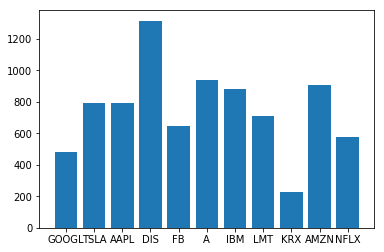

In [32]:
import matplotlib.pyplot as plt
plt.bar(range(len(bar_dict)),list(bar_dict.values()), align='center')
plt.xticks(range(len(bar_dict)), list(bar_dict.keys()))
plt.show()

#### Counting Itemsets (When to Buy)

In [97]:
minutes = sorted(list(set([d['minute'] for d in json_result])),reverse = False)

In [98]:
minuteCountStr = {key: "" for key in minutes}
for key in minute_baskets :
    for s in minutes :
        if any(d['minute'] == s for d in minute_baskets[key]):
            minuteCountStr[s] += "1"
        else :
            minuteCountStr[s] += "0"

In [99]:
listTime = []
for key in minuteCountStr :
    countVal = minuteCountStr[key].count('1')
    if countVal > 3 :
        listTime.append((key, countVal))
print(listTime)

[('09:31', 4), ('09:32', 4), ('09:33', 4), ('09:34', 4), ('09:35', 4), ('09:36', 4), ('09:37', 4), ('09:38', 4), ('09:39', 4), ('09:40', 4), ('09:41', 4), ('09:42', 4), ('09:44', 4), ('09:45', 4), ('09:46', 4), ('09:47', 4), ('09:48', 4), ('09:49', 4), ('09:50', 4), ('09:51', 4), ('09:52', 4), ('09:55', 4), ('09:56', 4), ('09:58', 4), ('09:59', 4), ('10:00', 4), ('10:01', 4), ('10:02', 4), ('10:03', 4), ('10:04', 4), ('10:05', 4), ('10:06', 4), ('10:07', 4), ('10:08', 4), ('10:09', 4), ('10:10', 4), ('10:11', 4), ('10:12', 4), ('10:13', 4), ('10:14', 4), ('10:15', 4), ('10:16', 4), ('10:17', 4), ('10:18', 4), ('10:19', 4), ('10:20', 4), ('10:21', 4), ('10:22', 4), ('10:23', 4), ('10:24', 4), ('10:25', 4), ('10:26', 4), ('10:27', 4), ('10:28', 4), ('10:29', 4), ('10:30', 4), ('10:31', 4), ('10:32', 4), ('10:33', 4), ('10:34', 4), ('10:35', 4), ('10:36', 4), ('10:37', 4), ('10:38', 4), ('10:39', 4), ('10:40', 4), ('10:41', 4), ('10:42', 4), ('10:43', 4), ('10:44', 4), ('10:45', 4), ('10:

#### Update

In [77]:
json_update_result = []
symbols = ['GOOGL','TSLA','AAPL','DIS','FB','A','IBM','LMT','KRX','AMZN','NFLX']
fail = 0
for comp_name in symbols :
    x_date = random.choice(dateRange)
    queryStr = "https://api.iextrading.com/1.0/stock/"+ comp_name +"/chart/1d"
    try:
        contents = requests.get(queryStr).json()
    except :
        fail += 1
    for x in contents :
        x['company'] = comp_name
    json_update_result += contents
    time.sleep(0.5)

In [82]:
filtered_update_result = [item for item in json_result if positive_filter(item)]

In [103]:
minute_update_basket_keys = sorted(list(set([d['date'] + "||" + d['minute'] for d in filtered_update_result])),reverse = False)
minute_update_baskets = {key: [] for key in minute_basket_keys}

In [104]:
unused_keys = ['date','label']
for x in filtered_update_result :
    min_key = x['date'] + "||" + x['minute']
    minute_update_baskets[min_key].append(without(x,unused_keys))

#### Counting Itemsets (What to buy)

In [105]:
for key in minute_update_baskets :
    for s in symbols :
        if any(d['company'] == s for d in minute_update_baskets[key]):
            compCountStr[s] = "1" + compCountStr[s][:-1]
        else :
            compCountStr[s] = "0" + compCountStr[s][:-1]

In [106]:
fail

1

In [107]:
bar_dict = {}
for key in compCountStr :
    bar_dict[key] = compCountStr[key].count('1')
bar_dict

{'GOOGL': 574,
 'TSLA': 343,
 'AAPL': 732,
 'DIS': 110,
 'FB': 902,
 'A': 30,
 'IBM': 350,
 'LMT': 21,
 'KRX': 15,
 'AMZN': 377,
 'NFLX': 788}

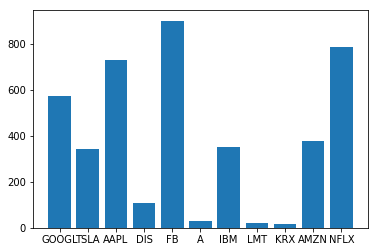

In [96]:
plt.bar(range(len(bar_dict)),list(bar_dict.values()), align='center')
plt.xticks(range(len(bar_dict)), list(bar_dict.keys()))
plt.show()

#### Counting Itemsets (When to Buy)

In [227]:
for key in minute_baskets :
    for s in minutes :
        if any(d['minute'] == s for d in minute_baskets[key]):
            minuteCountStr[s] = "1" + minuteCountStr[s][:-1]
        else :
            minuteCountStr[s] = "0" + minuteCountStr[s][:-1]

In [230]:
listTime = []
for key in minuteCountStr :
    countVal = minuteCountStr[key].count('1')
    if countVal > 0 :
        listTime.append((key, countVal))
print(listTime)

[('09:31', 4), ('09:32', 4), ('09:33', 3), ('09:34', 4), ('09:35', 4), ('09:36', 4), ('09:37', 4), ('09:38', 4), ('09:39', 3), ('09:40', 3), ('09:41', 3), ('09:42', 3), ('09:43', 3), ('09:44', 3), ('09:45', 4), ('09:46', 3), ('09:47', 3), ('09:48', 3), ('09:49', 3), ('09:50', 4), ('09:51', 3), ('09:52', 4), ('09:53', 3), ('09:54', 4), ('09:55', 3), ('09:56', 3), ('09:57', 3), ('09:58', 3), ('09:59', 3), ('10:00', 3), ('10:01', 3), ('10:02', 4), ('10:03', 4), ('10:04', 4), ('10:05', 4), ('10:06', 3), ('10:07', 4), ('10:08', 4), ('10:09', 4), ('10:10', 4), ('10:11', 4), ('10:12', 4), ('10:13', 4), ('10:14', 4), ('10:15', 4), ('10:16', 4), ('10:17', 4), ('10:18', 4), ('10:19', 4), ('10:20', 4), ('10:21', 4), ('10:22', 4), ('10:23', 3), ('10:24', 4), ('10:25', 3), ('10:26', 3), ('10:27', 4), ('10:28', 4), ('10:29', 4), ('10:30', 4), ('10:31', 4), ('10:32', 3), ('10:33', 3), ('10:34', 4), ('10:35', 4), ('10:36', 4), ('10:37', 4), ('10:38', 4), ('10:39', 4), ('10:40', 4), ('10:41', 4), ('10: